# Predict frame is voiced or unvoiced

In [18]:
import numpy as np
import h5py
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
%pylab inline

import matplotlib

Populating the interactive namespace from numpy and matplotlib


## Keras model
* DNN with relu activation, no dopout layer
* 2 output if the frame is voiced 1, 0 else 0, 1

In [19]:
hidden_layers = 6

In [20]:
model = Sequential()
model.add(Dense(512, input_dim=215, activation='relu'))
for i in range(0,hidden_layers):
    model.add(Dense(512, activation='relu'))
model.add(Dense(2))

model.summary()        

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_9 (Dense)                  (None, 512)           110592      dense_input_2[0][0]              
____________________________________________________________________________________________________
dense_10 (Dense)                 (None, 512)           262656      dense_9[0][0]                    
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 512)           262656      dense_10[0][0]                   
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 512)           262656      dense_11[0][0]                   
___________________________________________________________________________________________

In [21]:
model.compile(optimizer=SGD(lr=0.1), loss='mse', metrics=['accuracy'])

prepare training data, targets convert ot 1, 0 and 0, 1 

In [22]:
data = []
with h5py.File('preprocessed_data/train-standardized.h5','r') as hf:
    data = np.array(hf.get('dataset'))
input_data = data[:,0:215]
print(input_data.shape)
target_data = data[:,215:216]
target_data2 = []
for i in range(0,len(target_data)):
    if (target_data[i] > 0):
        target_data2.append([1,0])
    else:
        target_data2.append([0,1])
print(target_data.shape)

(216559, 215)
(216559, 1)


Rescale de validation and test inputs similar to the training data

In [23]:
def fix_input(data, columns, mean, std):
    column_av = np.array(mean)
    column_std = np.array(std)
    a = np.array(data)
    new_matrix = (a-column_av[np.newaxis,:])/column_std[np.newaxis,:]
    
    b = np.array(columns)
    ret = (a*(1-b[np.newaxis,:]))+(new_matrix*(b[np.newaxis,:]))
    return ret

In [24]:
mean_ = []
with h5py.File('preprocessed_data/train-mean.h5','r') as hf:
    mean_ = np.array(hf.get('dataset'))
std_ = []
with h5py.File('preprocessed_data/train-std.h5','r') as hf:
    std_ = np.array(hf.get('dataset'))
test = []
columns_ = np.zeros((243))
for i in range(200,215):
    columns_[i] = 1  

In [25]:
data_validation = []
with h5py.File('preprocessed_data/validation.h5','r') as hf:
    data_validation = np.array(hf.get('dataset'))
data_validation = fix_input(data=data_validation, columns=columns_, mean=mean_, std=std_)
input_validation = data_validation[:,0:215]
print(input_validation.shape)
target_validation = data_validation[:,215:216]
target_validation2 = []
for i in range(0,len(target_validation)):
    if (target_data[i] > 0):
        target_validation2.append([1,0])
    else:
        target_validation2.append([0,1])

(12594, 215)


### Learning, fix 410 epoch
(accuracy and loss for the validation data is not correct, but after the train we tested the network with new data

In [32]:
for i in range(0,10):
    model.fit(input_data, target_data2, nb_epoch=40, batch_size=1024,shuffle=True, verbose=0,
              validation_data=(input_validation, target_validation2))
    model.fit(input_data, target_data2, nb_epoch=1, batch_size=1024,shuffle=True, verbose=1,
              validation_data=(input_validation, target_validation2))

Train on 216559 samples, validate on 12594 samples
Epoch 1/1
216559/216559 [==============================] - 2s - loss: 0.0319 - acc: 0.9591 - val_loss: 0.4424 - val_acc: 0.5132
Train on 216559 samples, validate on 12594 samples
Epoch 1/1
216559/216559 [==============================] - 2s - loss: 0.0173 - acc: 0.9783 - val_loss: 0.4498 - val_acc: 0.5161
Train on 216559 samples, validate on 12594 samples
Epoch 1/1
216559/216559 [==============================] - 2s - loss: 0.0138 - acc: 0.9825 - val_loss: 0.4571 - val_acc: 0.5143
Train on 216559 samples, validate on 12594 samples
Epoch 1/1
216559/216559 [==============================] - 2s - loss: 0.0096 - acc: 0.9881 - val_loss: 0.4623 - val_acc: 0.5159
Train on 216559 samples, validate on 12594 samples
Epoch 1/1
216559/216559 [==============================] - 2s - loss: 0.0089 - acc: 0.9888 - val_loss: 0.4604 - val_acc: 0.5158
Train on 216559 samples, validate on 12594 samples
Epoch 1/1
216559/216559 [=============================

In [27]:
model.save('models_data/model_uv.h5')
model.save_weights('models_data/model_uv_weights.h5')

Load test data

In [26]:
with h5py.File('preprocessed_data/test.h5','r') as hf:
    test = np.array(hf.get('dataset')) 
test = fix_input(data=test, columns=columns_, mean=mean_, std=std_)

In [34]:
test_input = test[:,0:215]
test_target = test[:,215:216]

In [38]:
output_test = []
for test in test_input[0:2000]:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test))

### Test

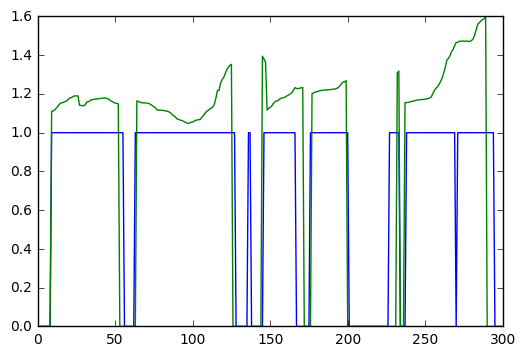

In [39]:
for o in output_test:
    if o[0][0] > o[0][1]:
        o[0][0] = 1
    else:
        o[0][0] = 0
output_test = np.array(output_test[0:300])[:,:,0]
output_test.shape
output_test = output_test.reshape(len(output_test))

plot(output_test)

targets = np.array(test_target)[:,0]
targets.shape
plot(targets[0:300]/100)